### Notebook showcasing how we would train the model using scikit-learn

Make sure you are logged in to wandb, and have o2 project

In [76]:
!wandb login

wandb: Currently logged in as: kydlicek-hynek (hynky). Use `wandb login --relogin` to force relogin


In [87]:
from utils import init_experiment
init_experiment({"dataset": "yelp2020"})

wandb: Currently logged in as: kydlicek-hynek (hynky). Use `wandb login --relogin` to force relogin


In [15]:
import pandas as pd
# point it to the files created by pipeline
train = pd.read_parquet("../artifacts/feature_store/yelp2020/train")
test = pd.read_parquet("../artifacts/feature_store/yelp2020/test")


# For training we don't need that much data
train = train.sample(400000, random_state=42)

In [8]:
num_features = ["user_age", "user_review_count", "user_cool", "user_funny", "user_fans", "user_average_stars", "user_compliment_cool", "user_compliment_cute", "user_compliment_list", "text_length", "text_words"]
categorical = ["stars"]
vector = ["text_tfidf"]
target = "usefulness"

In [89]:
from preprocessing import create_preprocessor
from utils import get_cv_metric
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

sgd = Pipeline(steps=[('preprocessor', create_preprocessor(num_features, categorical, vector)),
                            ('cv', GridSearchCV(SGDClassifier(), param_grid={'alpha': [0.01, 0.1]}, cv=5, verbose=1, n_jobs=4,
                                                scoring=get_cv_metric()
                                                
                                                ))
                            ], verbose=True)

# Don't use numerical values as we can't scale them
bayes = Pipeline(steps=[('preprocessor', create_preprocessor([], categorical, vector)),
                            ('cv', GridSearchCV(MultinomialNB(), param_grid={'alpha': [0.01, 0.1]}, cv=5, verbose=1, n_jobs=4,
                                                scoring=get_cv_metric()
                                                ))
                            ], verbose=True)

xgb = Pipeline(steps=[('preprocessor', create_preprocessor(num_features, categorical, vector)),
                            ('cv', GridSearchCV(XGBClassifier(), param_grid={'max_depth': [3, 5]}, cv=5, verbose=1, n_jobs=4,
                                                scoring=get_cv_metric()))
                            ], verbose=True)


models = {
    "sgd": sgd,
    "bayes": bayes,
    "xgb": xgb
}

In [90]:
# No splitting as we using external test set
assert(train.columns.equals(test.columns))
X_train = train.drop(target, axis=1)
y_train = train[target]

X_test = test.drop(target, axis=1)
y_test = test[target]

In [91]:
for model in models.values():
    model.fit(X_train, y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  48.1s
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Pipeline] ................ (step 2 of 2) Processing cv, total=  40.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  48.4s
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Pipeline] ................ (step 2 of 2) Processing cv, total=  13.3s


In [137]:
from typing import Dict
from matplotlib import pyplot as plt
from utils import Result, get_result
scores: Dict[str, Result] = {}

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    scores[name] = get_result(y_test, y_pred)

In [110]:
a = {name: score.metric_value for name, score in scores.items()}

In [115]:
df = pd.DataFrame(a, index=["result"]).T

<AxesSubplot: title={'center': 'Model Comparison'}, xlabel='Modles'>

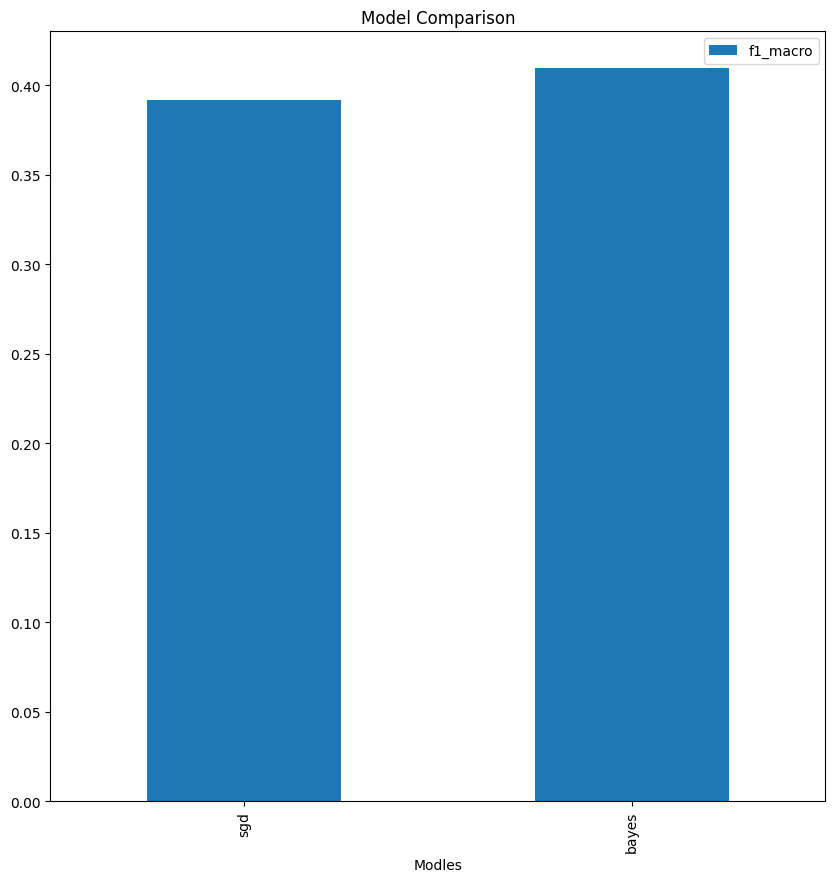

In [125]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
# Plot the scores
scores_df = pd.DataFrame({name: score.metric_value for name, score in scores.items()}, index=[get_cv_metric()]).T
scores_df.plot.bar(ax=ax, xlabel="Modles", title="Model Comparison")

In [133]:
best_model = max(scores.items(), key=lambda x: x[1].metric_value)

In [140]:
# Plot confusion matrix and show classification report
from sklearn.metrics import classification_report
from utils import create_confusion_matrix

fig, ax = plt.subplots(1,1, figsize=(10, 10))
y_pred = models[best_model[0]].predict(X_test)
labels = test[target].unique().tolist()


create_confusion_matrix(y_pred, y_test, ax=ax, labels=labels)
fig.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (976274005.py, line 10)

In [139]:
report = classification_report(y_test, y_pred, labels=labels, output_dict=True)
report_df = pd.DataFrame(report)
report_df

NameError: name 'y_pred' is not defined

In [132]:
from utils import save_experiment

a = save_experiment(models[best_model[0]], best_model[1])
